In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from tool_func import *
from hw2 import w11,w12,w21,w22
from scipy.optimize import minimize

# (A) Extension

# download data

In [2]:
try:
    adj_close_sys_df = pd.read_csv(r'E:\study\22fall\hf\data\hw5\SP500_components.csv',index_col=0)
except:
    #sp500 components
    sp_assets = pd.read_html(
            'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
    sym = sp_assets['Symbol'].str.replace('.','-').tolist()
    data = yf.download(tickers=sym,start = '2021-08-09',end = '2022-10-17')
    adj_close_sys_df = data.iloc[:,:503]
    adj_close_sys_df.columns = [i[1] for i in adj_close_sys_df.columns]
    adj_close_sys_df.to_csv(r'E:\study\22fall\hf\data\hw5\SP500_components.csv')

#discretionary stk tickers
discret_list = ['ALB','XOM','TSLA','CVX']
#transform index
adj_close_sys_df.index = pd.to_datetime((adj_close_sys_df.index))
adj_close_dis_df = adj_close_sys_df.loc[:,discret_list]

<ipython-input-2-00c876d4d0d9>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sym = sp_assets['Symbol'].str.replace('.','-').tolist()


[*********************100%***********************]  503 of 503 completed


# construct systematic portfolio

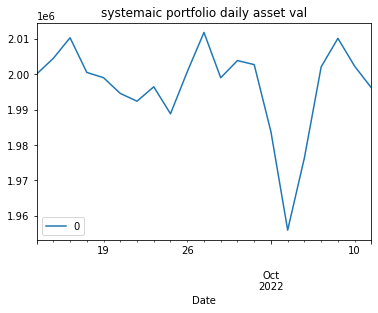

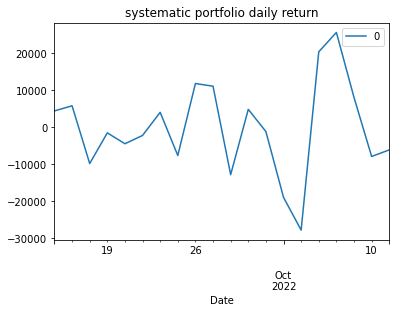

In [3]:
ror_sys_df = adj_close_sys_df/adj_close_sys_df.shift(1)-1
ror_sys_df.dropna(axis=0,inplace=True,how = 'all')
ror_sys_df.fillna(0,inplace=True)
mom_centered_df = momentum_factor(ror_sys_df,5,centered_func=np.median)

long_int = 100
short_int = 100
sys_pfl_weight_df = signal_sizing(mom_centered_df,'signal',long_nums=long_int,short_nums=short_int)
sys_pos = position(2e6,fix_notion_bool=True)
sys_pos.order_execute(weights_df=sys_pfl_weight_df.iloc[[-4*5-1],:],price_df=adj_close_sys_df.iloc[[-4*5-1],:],brokerage_fee_rate_float=0.0001)
sys_pos.order_execute(weights_df=sys_pfl_weight_df.iloc[[-3*5-1],:],price_df=adj_close_sys_df.iloc[[-3*5-1],:],brokerage_fee_rate_float=0.0001)
sys_pos.order_execute(weights_df=sys_pfl_weight_df.iloc[[-2*5-1],:],price_df=adj_close_sys_df.iloc[[-2*5-1],:],brokerage_fee_rate_float=0.0001)
sys_pos.order_execute(weights_df=sys_pfl_weight_df.iloc[[-1*5-1],:],price_df=adj_close_sys_df.iloc[[-1*5-1],:],brokerage_fee_rate_float=0.0001)
sys_pos.order_execute(weights_df=sys_pfl_weight_df.iloc[[0*5-1],:],price_df=adj_close_sys_df.iloc[[0*5-1],:],brokerage_fee_rate_float=0.0001)
sys_asset_val_df = sys_pos.daily_asset_val(price_df=adj_close_sys_df,all_price_bool=True)
sys_daily_ret_df = sys_asset_val_df - sys_asset_val_df.shift(1)
sys_daily_ret_df.dropna(axis=0,inplace=True)
sys_asset_val_df.plot()
plt.title('systemaic portfolio daily asset val')
sys_daily_ret_df.plot()
plt.title('systematic portfolio daily return')
plt.show()

# construct discretionary portfolio

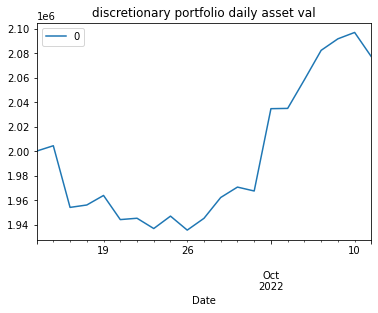

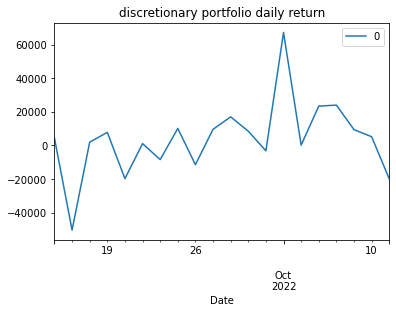

In [4]:
ror_dis_df = adj_close_dis_df/adj_close_dis_df.shift(1)-1
ror_dis_df.dropna(axis=0,inplace=True,how = 'all')
ror_dis_df.fillna(0,inplace=True)
dis_pfl_weight_df = pd.DataFrame(data = np.array([0.5,0.5,0.5*(w11+w21),0.5*(w12+w22)]).reshape(1,-1),columns = discret_list)
dis_pfl_weight_df.index = [ror_dis_df.index[0]]
dis_pfl_weight_df = dis_pfl_weight_df.reindex(ror_dis_df.index).ffill()
dis_pos = position(2e6,fix_notion_bool=True)
dis_pos.order_execute(weights_df=dis_pfl_weight_df.iloc[[-4*5-1],:],price_df=adj_close_dis_df.iloc[[-4*5-1],:],brokerage_fee_rate_float=0.0001)
dis_pos.order_execute(weights_df=dis_pfl_weight_df.iloc[[-3*5-1],:],price_df=adj_close_dis_df.iloc[[-3*5-1],:],brokerage_fee_rate_float=0.0001)
dis_pos.order_execute(weights_df=dis_pfl_weight_df.iloc[[-2*5-1],:],price_df=adj_close_dis_df.iloc[[-2*5-1],:],brokerage_fee_rate_float=0.0001)
dis_pos.order_execute(weights_df=dis_pfl_weight_df.iloc[[-1*5-1],:],price_df=adj_close_dis_df.iloc[[-1*5-1],:],brokerage_fee_rate_float=0.0001)
dis_pos.order_execute(weights_df=dis_pfl_weight_df.iloc[[0*5-1],:],price_df=adj_close_dis_df.iloc[[0*5-1],:],brokerage_fee_rate_float=0.0001)
dis_asset_val_df = dis_pos.daily_asset_val(price_df=adj_close_dis_df,all_price_bool=True)
dis_daily_ret_df = dis_asset_val_df - dis_asset_val_df.shift(1)
dis_daily_ret_df.dropna(axis=0,inplace=True)
dis_asset_val_df.plot()
plt.title('discretionary portfolio daily asset val')
dis_daily_ret_df.plot()
plt.title('discretionary portfolio daily return')
plt.show()

# For systematic portflio,
(1) We should consider alter the signal like change the period of data for momentum like switch
weekly return to monthly or even half-year return, which may show a better performance.  
(2) Besides momentum, maybe we should consider reversal effects in stocks  
(3) The market is suffering from high inflation and corresponding Fed's interest rate policy. Therefore, we should
look back in history when high inflation and raising interests rate operation happens to see how signals performed
back then. History may give us some insights into how to improve the strategy.
# For discretionary portflio,
(1) Discretionary portfolio's max_drawdown and VaR is bigger than systematic portfolio which shows that it is not well
hedged compared with systematic portfolio.We used market beta and momentum beta to hedge the discretionary portfolio.
In order to improve hedging performance, we may consider other risk factor like size to hedge or alter hedge ratio
dynamically on a weekly basis.

# (B) Selection

In [5]:
# download SPY
try:
    spy_close_df = pd.read_csv(r'E:\study\22fall\hf\data\hw5\spy_close.csv',index_col=0)
except:
    data = yf.download(tickers='SPY',start = '2021-08-09',end = '2022-10-30')
    spy_close_df = data.iloc[:,-2]
    spy_close_df.to_csv(r'E:\study\22fall\hf\data\hw5\spy_close.csv')

spy_ror_df = spy_close_df/spy_close_df.shift(1)-1
spy_ror_df.index = pd.to_datetime(spy_ror_df.index)
spy_ror_df.columns = ['SPY']
spy_ror_df.dropna(axis=0,inplace=True)

sys_ror_df = sys_asset_val_df/sys_asset_val_df.shift(1)-1
sys_ror_df.dropna(axis=0,inplace=True)
dis_ror_df = dis_asset_val_df/dis_asset_val_df.shift(1)-1
dis_ror_df.dropna(axis=0,inplace=True)
spy_ror_df = spy_ror_df.reindex(sys_ror_df.index)
# cal
sys_IR_float = IR(sys_ror_df.values,spy_ror_df.values)
sys_beta_float = cal_beta(sys_ror_df.values,spy_ror_df.values)
sys_sharp_float = sharp(sys_ror_df.values)
sys_maxdrawdown_float = max_drawdown(sys_asset_val_df)
sys_VaR_float = VaR(0.75,sys_daily_ret_df)
sys_ETL_float = ETL(0.75,sys_daily_ret_df)
sys_annual_ror_float = annualized_ror(sys_ror_df.values.copy())[0]
dis_IR_float = IR(dis_ror_df.values,spy_ror_df.values)
dis_beta_float = cal_beta(dis_ror_df.values,spy_ror_df.values)
dis_sharp_float = sharp(dis_ror_df.values)
dis_maxdrawdown_float = max_drawdown(dis_asset_val_df)
dis_VaR_float = VaR(0.75,dis_daily_ret_df)
dis_ETL_float = ETL(0.75,dis_daily_ret_df)
dis_annual_ror_float = annualized_ror(dis_ror_df.values.copy())[0]
stats_df = pd.DataFrame(data = [[sys_IR_float,sys_beta_float,sys_sharp_float,sys_maxdrawdown_float,sys_VaR_float,sys_ETL_float,sys_annual_ror_float],
                                [dis_IR_float,dis_beta_float,dis_sharp_float,dis_maxdrawdown_float,dis_VaR_float,dis_ETL_float,dis_annual_ror_float]])
stats_df = stats_df.T
stats_df.index = ['Annualized IR','Beta','Annualized Sharp','max drawdown','VaR','ETL','AnnualizedRor']
stats_df.columns = ['Systematic','Discretionary']
print(stats_df)

[*********************100%***********************]  1 of 1 completed
                    Systematic  Discretionary
Annualized IR         4.218383       5.412760
Beta                 -0.235277       0.305301
Annualized Sharp     -0.579270       3.294935
max drawdown      55768.541922   68873.160504
VaR               -7736.437649   -5794.962082
ETL              -15424.882659  -21938.364146
AnnualizedRor        -0.024171       0.609811


Apparently, from IR and sharp, Discretionary portfolio's performance is much better than Systematic portfolio right now.
However, systematic portfolio's risk performance is better than discretionary portfolio in max_drawdown,VaR and ETL.
Though systematic portfolio's sharp is negative right now, if we extend its backtest period it may show a better
performance considering its risk performance.
In the end, I would still choose discretionary portfolio since I don't think weekly momentum signal is a good signal right now.

# (C) Trading Recommendation
I highly recommend we trade discretionary portfolio. Though it has flaws in risk performance, I still believe that oil
and lithium will be the hotest inhvestment sector under current situation, both economically and politically. On the
other side, I think its relative high risk is due to inappropriate hedging choice, which can be solved or at least eased
if we use solutions mentioned in (A)

# (D) Allocation

In [6]:
strat_corr_float = sys_ror_df.corrwith(dis_ror_df)[0]
print(f'correlationship between these two strategies: {strat_corr_float}')
#first trial: use quais-Netwon optimization to maximize portfolio's IR

correlationship between these two strategies: -0.1070216565738381


I want to use a objective function similar to mean variance optimization to calculate the reasonable weights for each of the two strategies in the portfolios.
It is basically a simplified mean variance optimization loss function with weights over VaR to punish VaR and replace mean(return) with IR to maximize IR.

Systematic portfolio"s weight:0.39897782480012306, Discretionary portfolio"s weight: 0.601022175199877


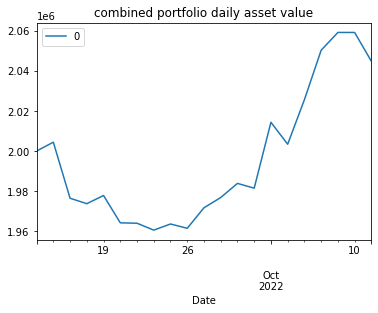

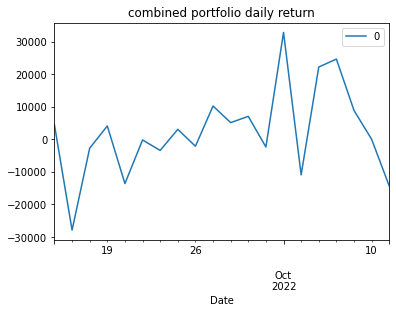

                    Systematic  Discretionary     portfolio
Annualized IR         4.218383       5.412760      5.335645
Beta                 -0.235277       0.305301      0.089622
Annualized Sharp     -0.579270       3.294935      2.698187
max drawdown      55768.541922   68873.160504  43821.180390
VaR               -7736.437649   -5794.962082  -3076.861614
ETL              -15424.882659  -21938.364146 -14053.634592
AnnualizedRor        -0.024171       0.609811      0.325471


In [7]:
#objective function
def obj_IR(w0_float):
    sys_ror_array = sys_ror_df.values.reshape(-1,1)
    dis_ror_array = dis_ror_df.values.reshape(-1,1)
    pfl_ror_array = w0_float*sys_ror_array+(1-w0_float)*dis_ror_array
    pfl_std_float = np.std(pfl_ror_array)*np.sqrt(252)
    VaR_float = VaR(0.75,pd.DataFrame(data = pfl_ror_array),period_int=252)
    IR_float = IR(pfl_ror_array,spy_ror_df.values)
    IR_float -= 4*pfl_std_float #punish volatlity
    IR_float += 4*VaR_float #punish VaR * weight
    return -IR_float

#BFGS optimize with w0+w1 =1, wi>0 constrains
res = minimize(obj_IR,[0.5],bounds=[[0,1]])
w0 = res.x[0]
print(f'Systematic portfolio"s weight:{w0}, Discretionary portfolio"s weight: {1-w0}')
pfl_ror_df = w0*sys_ror_df+(1-w0)*dis_ror_df
pfl_asset_val_df = w0*sys_asset_val_df+(1-w0)*dis_asset_val_df
pfl_daily_ret_df = (pfl_asset_val_df-pfl_asset_val_df.shift(1)).dropna(axis=0)
#plot
pfl_asset_val_df.plot()
plt.title('combined portfolio daily asset value')
plt.show()
pfl_daily_ret_df.plot()
plt.title('combined portfolio daily return')
plt.show()
#cal statsitics
pfl_IR_float = IR(pfl_ror_df.values,spy_ror_df.values)
pfl_beta_float = cal_beta(pfl_ror_df.values,spy_ror_df.values)
pfl_sharp_float = sharp(pfl_ror_df.values)
pfl_maxdrawdown_float = max_drawdown(pfl_asset_val_df)
pfl_VaR_float = VaR(0.75,pfl_daily_ret_df)
pfl_ETL_float = ETL(0.75,pfl_daily_ret_df)
pfl_annual_ror_float = annualized_ror(pfl_ror_df.values.copy())[0]
stats_df.loc[:,'portfolio'] = [pfl_IR_float,pfl_beta_float,pfl_sharp_float,pfl_maxdrawdown_float,pfl_VaR_float,pfl_ETL_float,pfl_annual_ror_float]
print(stats_df)
pass



# (E) Fund Structure
(1) I think our strategy's capacity's is not very large. Therefore, we should not consider complicated fund structure
like Master-feeder or mini-master to minimize tax cost to cater to foreign investors or US tax-exempt investors but
just set up a domestic fund focusing on U.S. taxable investors in Delaware.
(2) As to the fee structure, I think we should employ the mode of management fee (2%) applying to AUM and performance
fee(20%) applying to assets' appreciation.